### **Importing Libraries**

In [ ]:
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import nltk, re, string
from string import punctuation
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import  accuracy_score, f1_score, precision_score,confusion_matrix, recall_score, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import PassiveAggressiveClassifier,LogisticRegression
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from google.colab import drive
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

### **Loading DataSet**

In [ ]:
#read dataset into the dataframe
df = pd.read_csv('/content/disaster_tweets.csv')
df.head()


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [ ]:
df.shape

(7613, 5)

### **Target Distribution**

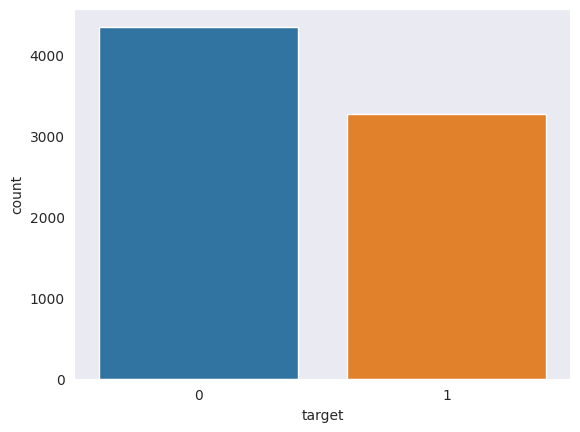

In [ ]:
# Set the style to "dark"
sns.set_style("dark")
# Create a countplot for the target variable in your DataFrame
sns.countplot(data=df, x='target') #0-normal tweets 1- disaster tweets
# Show the plot
plt.show()

### **Creating new column for storing length of tweets**

In [ ]:
# creating new column for storing length of tweets
df['length'] = df['text'].apply(len)
df.head()


,id,keyword,location,text,target,length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88


<Axes: ylabel='Frequency'>

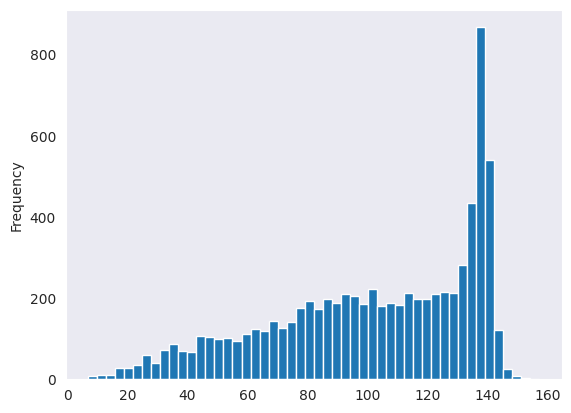

In [ ]:
df['length'].plot(bins=50, kind='hist')

In [ ]:
#generates summary statistics for the values in the "length" column
df.length.describe()

count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

In [ ]:
# find a tweet whose length is 157 characters
df[df['length'] == 157]['text'].iloc[0]

"when you're taking a shower and someone flushes the toilet and you have .1 second to GTFO or you get burned??????????????????????????????????????????????????"

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

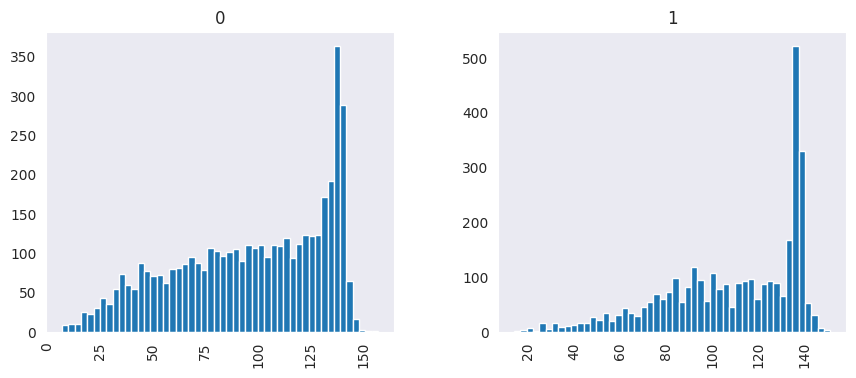

In [ ]:
# displays the distribution of tweet lengths for target variables
df.hist(column='length', by='target', bins=50,figsize=(10,4))

In [ ]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

# Removing stop words which are unneccesary from headline news
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

df_1 = df[df['target']==1]
df_0 = df[df['target']==0]
df_1['text']=df_1['text'].apply(remove_stopwords)
df_0['text']=df_0['text'].apply(remove_stopwords)

<ipython-input-12-812a15432658>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['text']=df_1['text'].apply(remove_stopwords)
<ipython-input-12-812a15432658>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_0['text']=df_0['text'].apply(remove_stopwords)


### **Plotting wordcloud of Disaster Tweets**

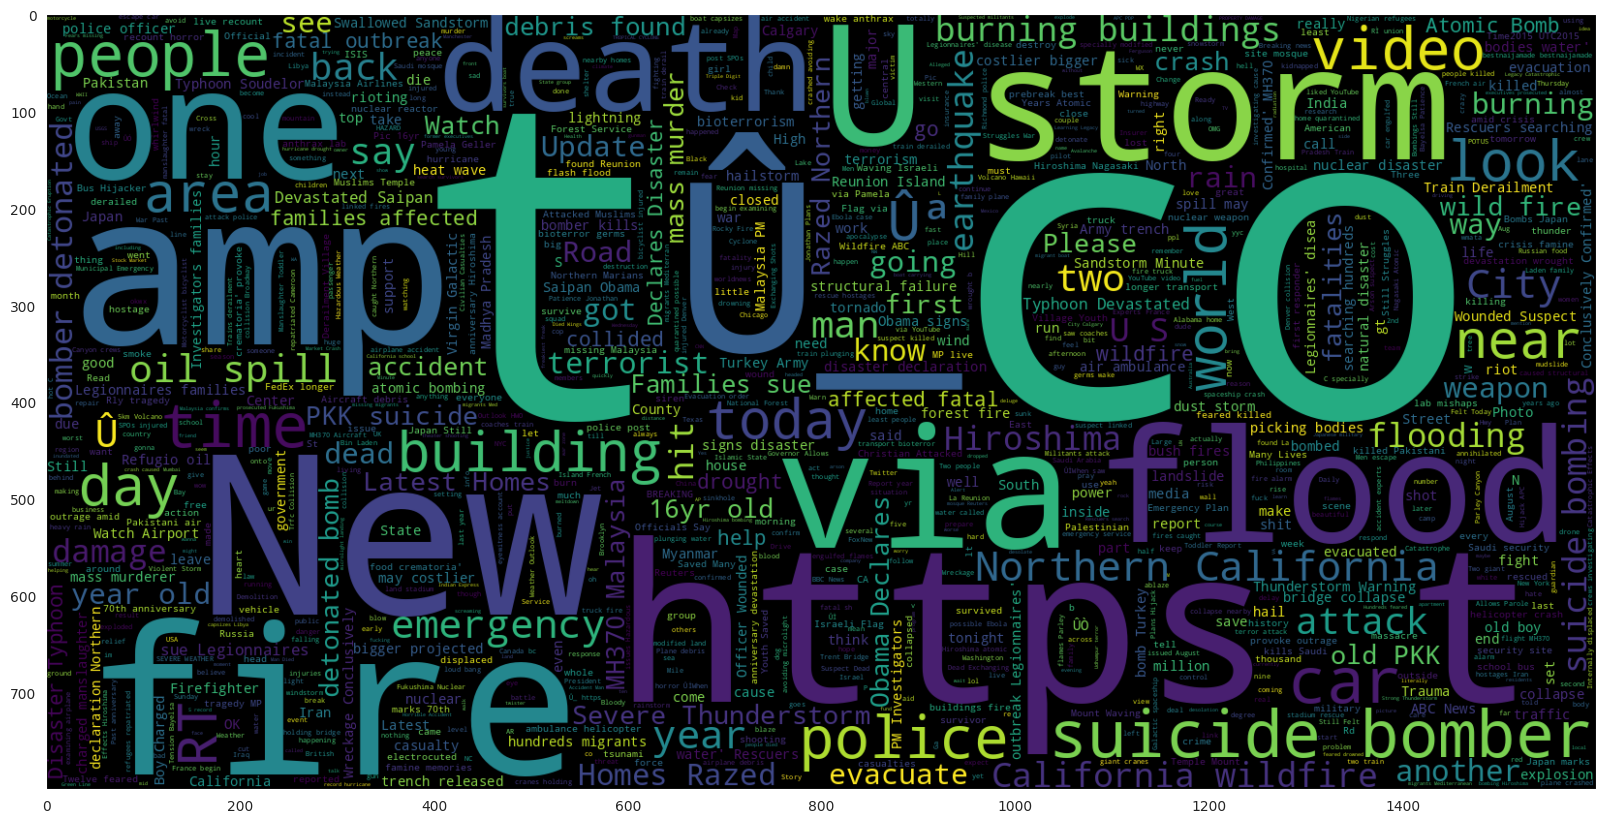

In [ ]:
#WordCloud library visualize the most frequently occurring words
from wordcloud import WordCloud
plt.figure(figsize = (20,20)) # Text that is Disaster tweets
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800).generate(" ".join(df_1.text))
plt.imshow(wc , interpolation = 'bilinear')

### **Plotting wordcloud of Normal Tweets**

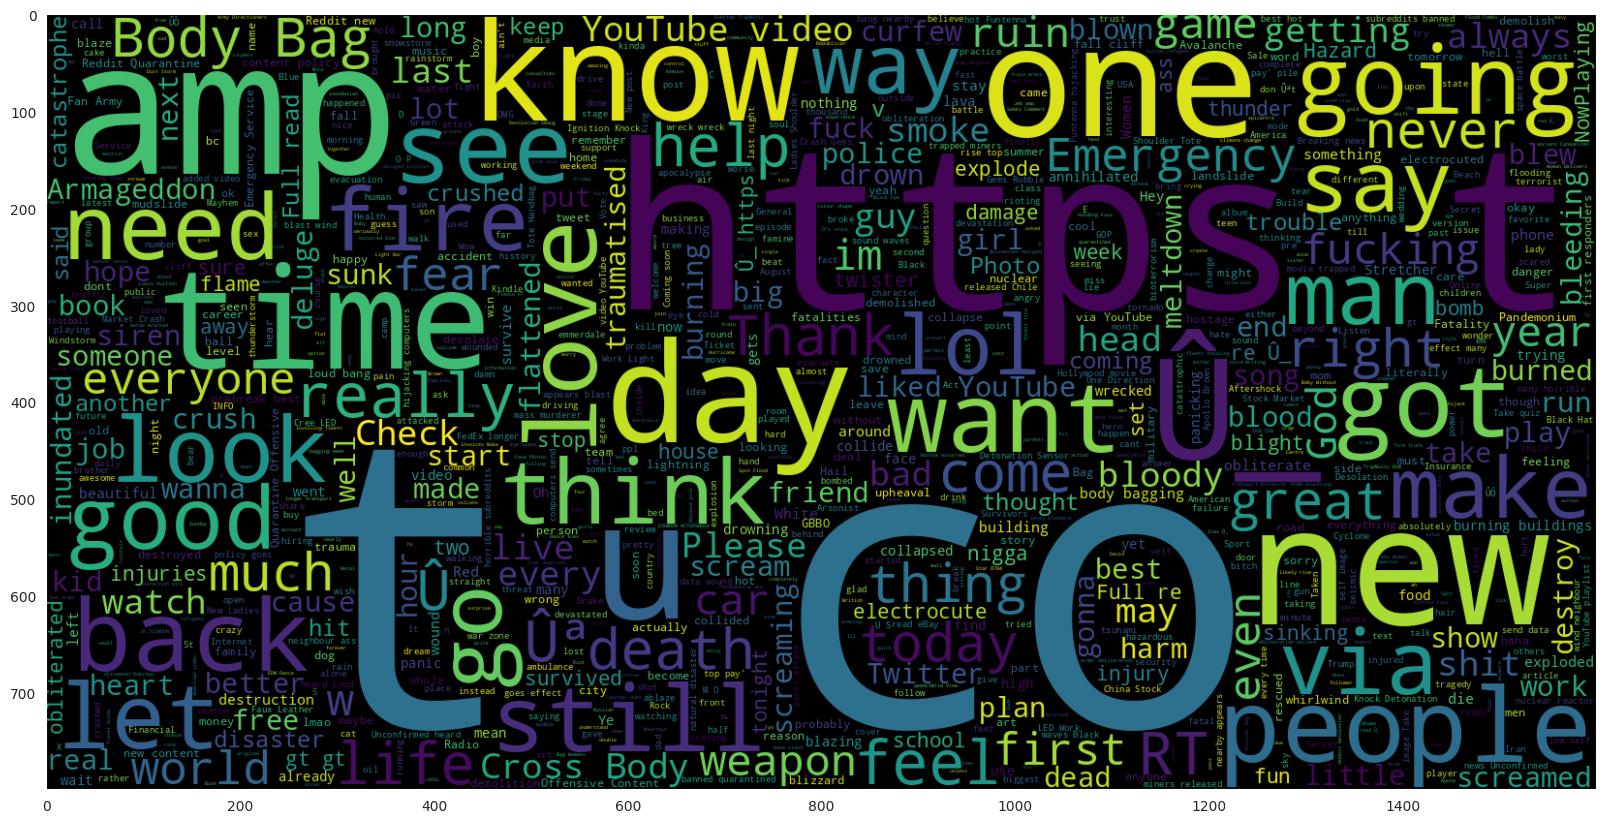

In [ ]:
#WordCloud library visualize the most frequently occurring words
plt.figure(figsize = (20,20)) # Text that is Normal Tweets
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800).generate(" ".join(df_0.text))
plt.imshow(wc , interpolation = 'bilinear')

### **Data Cleaning and Preparation**

In [ ]:
from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer()
#creating list of possible stopwords from nltk library
stop = stopwords.words('english')

def cleanTweet(txt):
  # lowercaing
    txt = txt.lower()
    # tokenization
    words = nltk.word_tokenize(txt)
  # removing stopwords & Lemmatizing the words
    words = ' '.join([lemma.lemmatize(word) for word in words if word not in (stop)])
    text = "".join(words)
  # removing non-alphabetic characters
    txt = re.sub('[^a-z]',' ',text)
    return txt

### **Applying Clean Tweet Function on Tweets Text**

In [ ]:
#diplays th clean tweets
df['cleaned_tweets'] = df['text'].apply(cleanTweet)
df.head()


,id,keyword,location,text,target,length,cleaned_tweets
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,deed reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,resident asked shelter place notified offic...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,people receive wildfire evacuation or...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,got sent photo ruby alaska smoke wildfire ...


### **Creating Feature & Target Variables**

In [ ]:
#defining the target variable y and the feature variable X
y = df.target
X=df.cleaned_tweets

In [ ]:
#split your data into training and testing sets
#specifies that 20% of the data will be used as the testing set, and the remaining 80% will be used as the training set
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20,stratify=y, random_state=0)

### **TF-IDF Vectorizer - Bi-Gram**

In [ ]:
#transform the text data in your training and testing sets into TF-IDF features.
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8, ngram_range=(1,2)) #considering unigram and bigram as features
tfidf_train_2 = tfidf_vectorizer.fit_transform(X_train)  #fits the vectorizer to the training data and transforms the training data into TF-IDF features.
tfidf_test_2 = tfidf_vectorizer.transform(X_test)  #transforms the testing data into TF-IDF features using the same vectorizer that was fitted to the training data.


### **Multinomial Naive Bayes**

In [ ]:
#fitting a MNB classifier to training data that has been transformed into TF-IDF features
#Model Fitting
mnb_tf = MultinomialNB()
mnb_tf.fit(tfidf_train_2, y_train)


MultinomialNB()

### **10-Fold Cross Validation**

In [ ]:
#k-fold cross-validation to evaluate the MNB classifier's performance on training data, obtaining the mean accuracy of MNB
from sklearn import model_selection

kfold = model_selection.KFold(n_splits=10)
scoring = 'accuracy'

acc_mnb2 = cross_val_score(estimator = mnb_tf, X = tfidf_train_2, y = y_train, cv = kfold,scoring=scoring)
acc_mnb2.mean()  #calculates the mean accuracy across the 10 cross-validation folds

0.7922824302134648

### **Model Prediction Test set**

,Model,Accuracy,Precision,Sensitivity,Specificity,F1 Score
0,Multinomial Naive Bayes - TFIDF-Bigram,0.800394,0.858607,0.640673,0.920598,0.7338


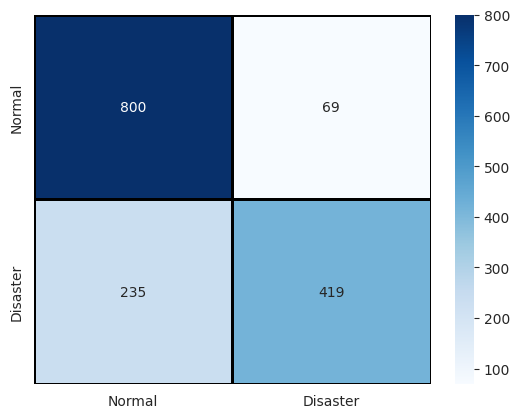

In [ ]:
#evaluation of the Multinomial Naive Bayes model's performance on the testing data
pred_mnb2 = mnb_tf.predict(tfidf_test_2)
CM=confusion_matrix(y_test,pred_mnb2)
sns.heatmap(CM,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Normal', 'Disaster'] , yticklabels = ['Normal', 'Disaster'])

TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]
specificity = TN/(TN+FP)

acc= accuracy_score(y_test, pred_mnb2)

prec = precision_score(y_test, pred_mnb2)
rec = recall_score(y_test, pred_mnb2)
f1 = f1_score(y_test, pred_mnb2)


model_results =pd.DataFrame([['Multinomial Naive Bayes - TFIDF-Bigram',acc, prec,rec,specificity, f1]],
               columns = ['Model', 'Accuracy','Precision', 'Sensitivity','Specificity', 'F1 Score'])

model_results

### **Passive Aggressive Classifier**

In [ ]:
#training a Passive Aggressive Classifier on training data that has been transformed into TF-IDF features
pass_tf = PassiveAggressiveClassifier()
pass_tf.fit(tfidf_train_2, y_train)

PassiveAggressiveClassifier()

### **10-Fold Cross Validation**

In [ ]:
#obtaining the mean accuracy of Passive Aggressive Classifier across 10 cross-validation folds and obtain the mean accuracy
kfold = model_selection.KFold(n_splits=10)
scoring = 'accuracy'

acc_pass2 = cross_val_score(estimator = pass_tf, X = tfidf_train_2, y = y_train, cv = kfold,scoring=scoring)
acc_pass2.mean()

0.786535303776683

### **Model Prediction**

<ipython-input-26-cb9ec57dd8e0>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = model_results.append(results, ignore_index = True)


,Model,Accuracy,Precision,Sensitivity,Specificity,F1 Score
0,Multinomial Naive Bayes - TFIDF-Bigram,0.800394,0.858607,0.640673,0.920598,0.733800
1,Passive Aggressive Classifier - TFIDF-Bigram,0.783322,0.741071,0.761468,0.920598,0.751131


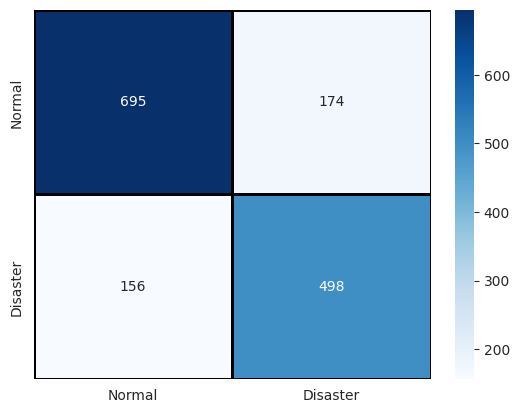

In [ ]:
# evaluating the Passive Aggressive Classifier's performance on the testing data,
#comparing it to the Multinomial Naive Bayes model
#compare the performance of different models.
pred_pass2 = pass_tf.predict(tfidf_test_2)
CM=confusion_matrix(y_test,pred_pass2)
sns.heatmap(CM,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Normal', 'Disaster'] , yticklabels = ['Normal', 'Disaster'])

acc = accuracy_score(y_test, pred_pass2)
prec = precision_score(y_test, pred_pass2)
rec = recall_score(y_test, pred_pass2)
f1 = f1_score(y_test, pred_pass2)

results =pd.DataFrame([['Passive Aggressive Classifier - TFIDF-Bigram',acc, prec,rec,specificity, f1]],
               columns = ['Model', 'Accuracy','Precision', 'Sensitivity','Specificity', 'F1 Score'])
results = model_results.append(results, ignore_index = True)
results

### **TF-IDF Vectorizer - Tri Gram**

In [ ]:
#transform the text data in your training and testing sets into TF-IDF features.
tfidf_vectorizer_3 = TfidfVectorizer(stop_words='english', max_df=0.8, ngram_range=(1,3)) #considering unigram,bigram and trigram as features
tfidf_train_3 = tfidf_vectorizer_3.fit_transform(X_train)
tfidf_test_3 = tfidf_vectorizer_3.transform(X_test)

### **Multinomial Naive Bayes - Tri Gram**

In [ ]:
# fitting a (MNB) classifier to your training data, including unigrams, bigrams, and trigrams
mnb_tf3 = MultinomialNB()
mnb_tf3.fit(tfidf_train_3, y_train)

MultinomialNB()

### **10-fold cross validation**

In [ ]:
# obtaining the mean accuracy of your Multinomial Naive Bayes model across 10 cross-validation folds
kfold = model_selection.KFold(n_splits=10)
scoring = 'accuracy'

acc_mnb3 = cross_val_score(estimator = mnb_tf, X = tfidf_train_3, y = y_train, cv = kfold,scoring=scoring)
acc_mnb3.mean()


0.7845648604269294

### **Model Prediction**

<ipython-input-30-7ca5d0091f83>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(mod_results, ignore_index = True)


,Model,Accuracy,Precision,Sensitivity,Specificity,F1 Score
0,Multinomial Naive Bayes - TFIDF-Bigram,0.800394,0.858607,0.640673,0.920598,0.733800
1,Passive Aggressive Classifier - TFIDF-Bigram,0.783322,0.741071,0.761468,0.920598,0.751131
2,Multinomial Naive Bayes - TFIDF-Trigram,0.798424,0.866808,0.626911,0.920598,0.727595


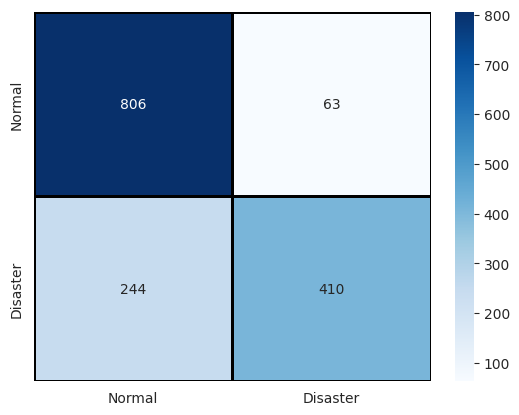

In [ ]:
#evaluating the Multinomial Naive Bayes model's performance on the testing data
#compare the performance of different models
pred_mnb3 = mnb_tf3.predict(tfidf_test_3)
CM=confusion_matrix(y_test,pred_mnb3)
sns.heatmap(CM,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Normal', 'Disaster'] , yticklabels = ['Normal', 'Disaster'])

acc = accuracy_score(y_test, pred_mnb3)
prec = precision_score(y_test, pred_mnb3)
rec = recall_score(y_test, pred_mnb3)
f1 = f1_score(y_test, pred_mnb3)

mod_results =pd.DataFrame([['Multinomial Naive Bayes - TFIDF-Trigram',acc, prec,rec,specificity, f1]],
               columns = ['Model', 'Accuracy','Precision', 'Sensitivity','Specificity', 'F1 Score'])
results = results.append(mod_results, ignore_index = True)
results

### **Passive Aggressive Classifier - Tri Gram**

In [ ]:
 #training a Passive Aggressive Classifier on your training data with unigrams, bigrams, and trigrams.
 #using k-fold cross-validation to evaluate the classifier's performance.

pass_tf3 = PassiveAggressiveClassifier()
pass_tf3.fit(tfidf_train_3, y_train)

## cross validation
kfold = model_selection.KFold(n_splits=10)
scoring = 'accuracy'

acc_pass3 = cross_val_score(estimator = pass_tf3, X = tfidf_train_3, y = y_train, cv = kfold,scoring=scoring)
acc_pass3.mean()

0.7916256157635468

<ipython-input-32-37390befdb89>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(mod1_results, ignore_index = True)


,Model,Accuracy,Precision,Sensitivity,Specificity,F1 Score
0,Multinomial Naive Bayes - TFIDF-Bigram,0.800394,0.858607,0.640673,0.920598,0.733800
1,Passive Aggressive Classifier - TFIDF-Bigram,0.783322,0.741071,0.761468,0.920598,0.751131
2,Multinomial Naive Bayes - TFIDF-Trigram,0.798424,0.866808,0.626911,0.920598,0.727595
3,Passive Aggressive Classifier - TFIDF-Trigram,0.778726,0.725462,0.779817,0.920598,0.751658


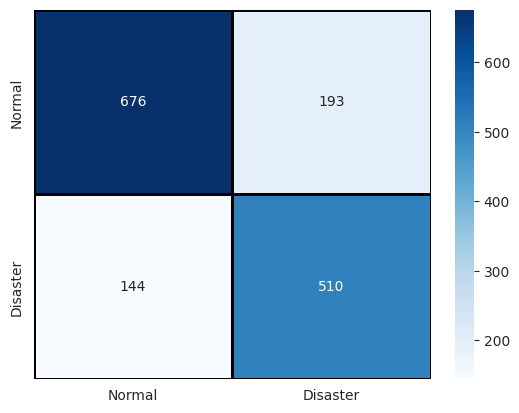

In [ ]:
#evaluating the Passive Aggressive Classifier's performance on the testing data
pred_pass3 = pass_tf3.predict(tfidf_test_3)
CM=confusion_matrix(y_test,pred_pass3)
sns.heatmap(CM,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Normal', 'Disaster'] , yticklabels = ['Normal', 'Disaster'])

acc = accuracy_score(y_test, pred_pass3)
prec = precision_score(y_test, pred_pass3)
rec = recall_score(y_test, pred_pass3)
f1 = f1_score(y_test, pred_pass3)

mod1_results =pd.DataFrame([['Passive Aggressive Classifier - TFIDF-Trigram',acc, prec,rec,specificity, f1]],
               columns = ['Model', 'Accuracy','Precision', 'Sensitivity','Specificity', 'F1 Score'])
results = results.append(mod1_results, ignore_index = True)
results

### **Most Informative Features**

In [ ]:
#display the most informative features for a binary classification problem when using  TF-IDF and a classifier MNB AND PAC
#It helps identify the words or features that are most indicative of each class "Normal" and "Disaster"

def most_informative_feature_for_binary_classification(vectorizer, classifier, n=100):
    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names_out()
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]

    for coef, feat in topn_class1:
        print(class_labels[0], coef, feat)

    print()

    for coef, feat in reversed(topn_class2):
        print(class_labels[1], coef, feat)


In [ ]:
#print most indicative features for class 0 (Normal) and class 1(Disaster) based on the coefficients of the classifier.
most_informative_feature_for_binary_classification(tfidf_vectorizer_3, pass_tf3, n=10)

0 -2.1195912975519646 let
0 -2.026540701196229 love
0 -1.9108458911598125 suicide bomb
0 -1.8113172143354448 bag
0 -1.809649341407271 hrqcjdovjz
0 -1.809649341407271 http hrqcjdovjz
0 -1.809649341407271 mishap http hrqcjdovjz
0 -1.8061721331243037 new
0 -1.7858205350066076 flattened
0 -1.7063101906585711 australia http trhjuau

1 3.9808179411309643 http
1 3.79672883340392 hiroshima
1 3.4178142955157145 california
1 3.314638977351349 wildfire
1 3.0268306305454993 train
1 2.979351716434291 building
1 2.863456325749265 forest
1 2.838023064737594 flood
1 2.836384154189273 bombing
1 2.6459096296282323 killed


### **Sample prediction**

we will use our best model to predict sample tweets for checking the overall validity of the model,here we have used passive Aggressive classifier

In [ ]:
sentences = [
  "Just happened a terrible car crash",
    "Heard about #earthquake is different cities, stay safe everyone.",
    "No I don't like cold!",
    "@RosieGray Now in all sincerety do you think the UN would move to Israel if there was a fraction of a chance of being annihilated? "
  ]

tfidf_trigram = tfidf_vectorizer_3.transform(sentences)


predictions = pass_tf3.predict(tfidf_trigram)

for text, label in zip(sentences, predictions):
    if label==1:
        target="Disaster Tweet"
        print("text:", text, "\nClass:", target)
        print()
    else:
        target="Normal Tweet"
        print("text:", text, "\nClass:", target)
        print()


text: Just happened a terrible car crash 
Class: Disaster Tweet

text: Heard about #earthquake is different cities, stay safe everyone. 
Class: Disaster Tweet

text: No I don't like cold! 
Class: Normal Tweet

text: @RosieGray Now in all sincerety do you think the UN would move to Israel if there was a fraction of a chance of being annihilated?  
Class: Normal Tweet

